In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-09-19 11:58:46.169961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Create on/off subregion

In [116]:
def get_axes(c,A):
    a = np.sqrt(A/(c*np.pi))
    b = a*c
    return a,b

def ellipse_fn(a,b):
    def f(x,y):
        return 1 - (x/a)**2 - (y/b)**2
    return f

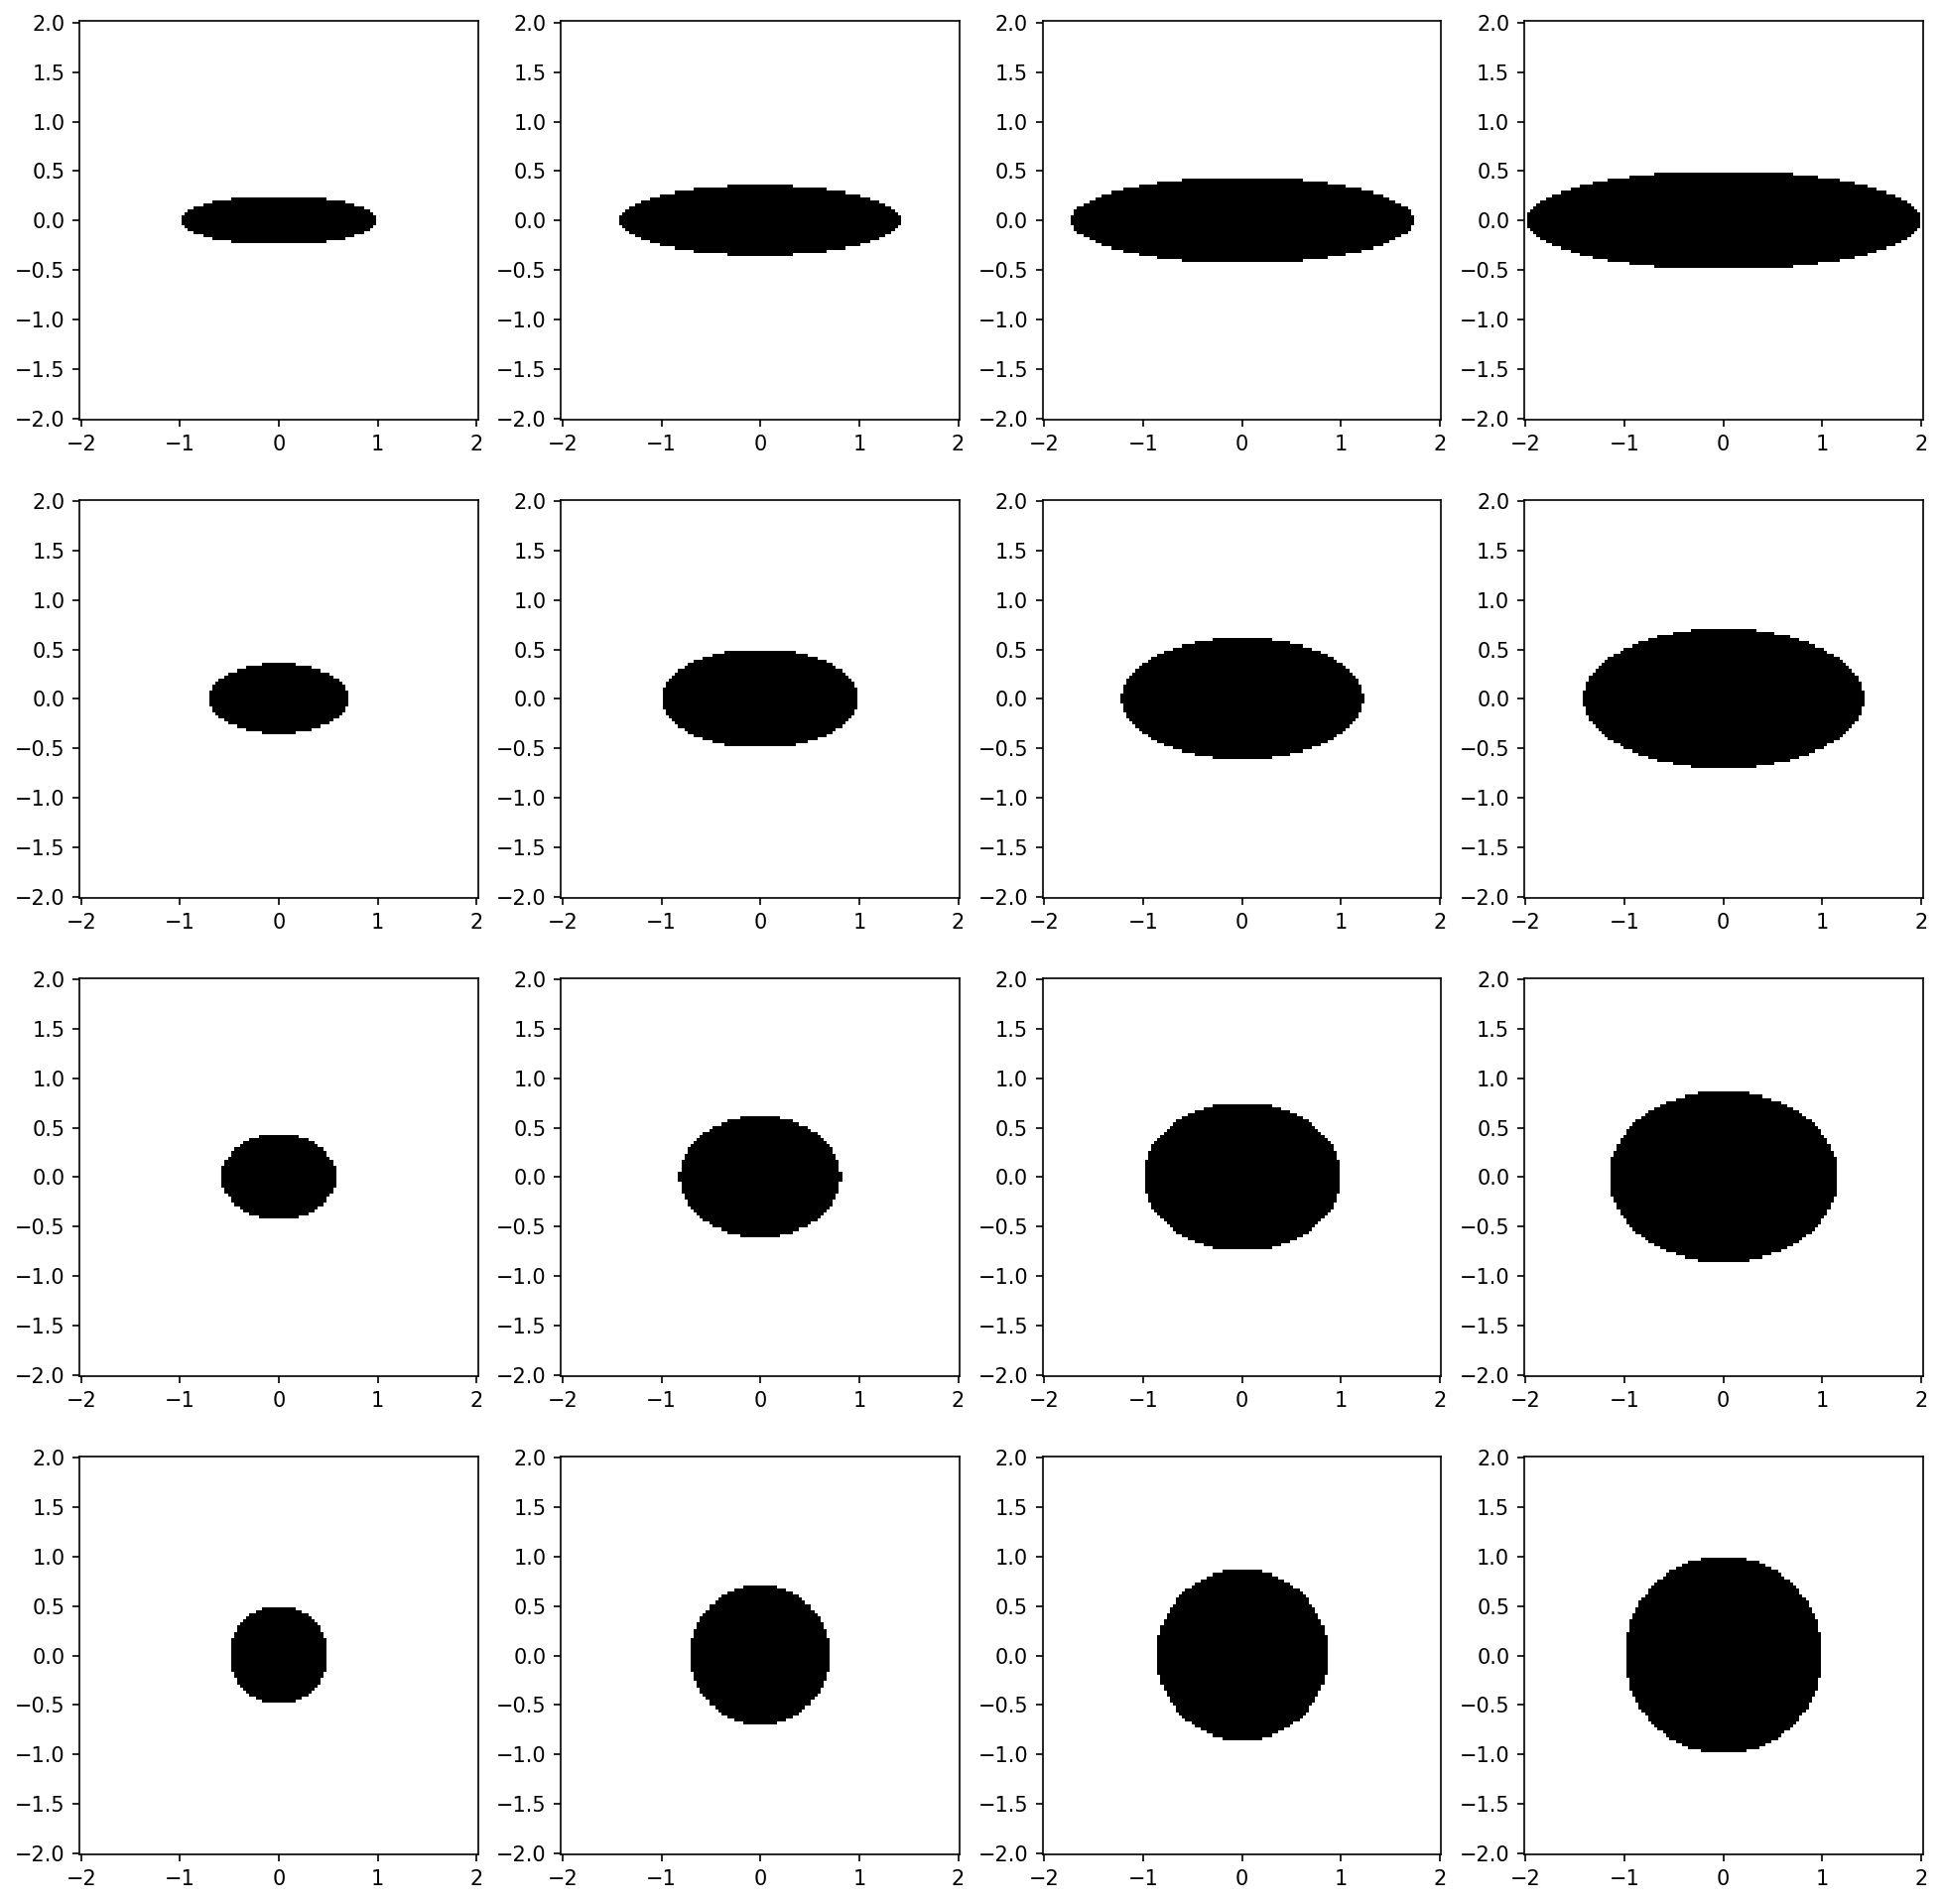

In [118]:
N = 128
L = 4

pts = np.arange(N+1)*L/N - L/2
x,y = np.meshgrid(pts,pts)
extent = (pts[0]-(L/N)/2,pts[-1]+(L/N)/2,pts[0]-(L/N)/2,pts[-1]+(L/N)/2)

fig,axs = plt.subplots(4,4,figsize=(16,16),dpi=150)

for i,c in enumerate([0.25,0.5,0.75,1]):
    for j,A in enumerate([0.25*np.pi,0.5*np.pi,0.75*np.pi,np.pi]):
        ellipse = (ellipse_fn(*get_axes(c,A))(x,y) > 0).astype(int)

        axs[i,j].imshow(ellipse,cmap='binary',origin='lower',extent=extent)

# Calculate on/off subregion correlation and bias

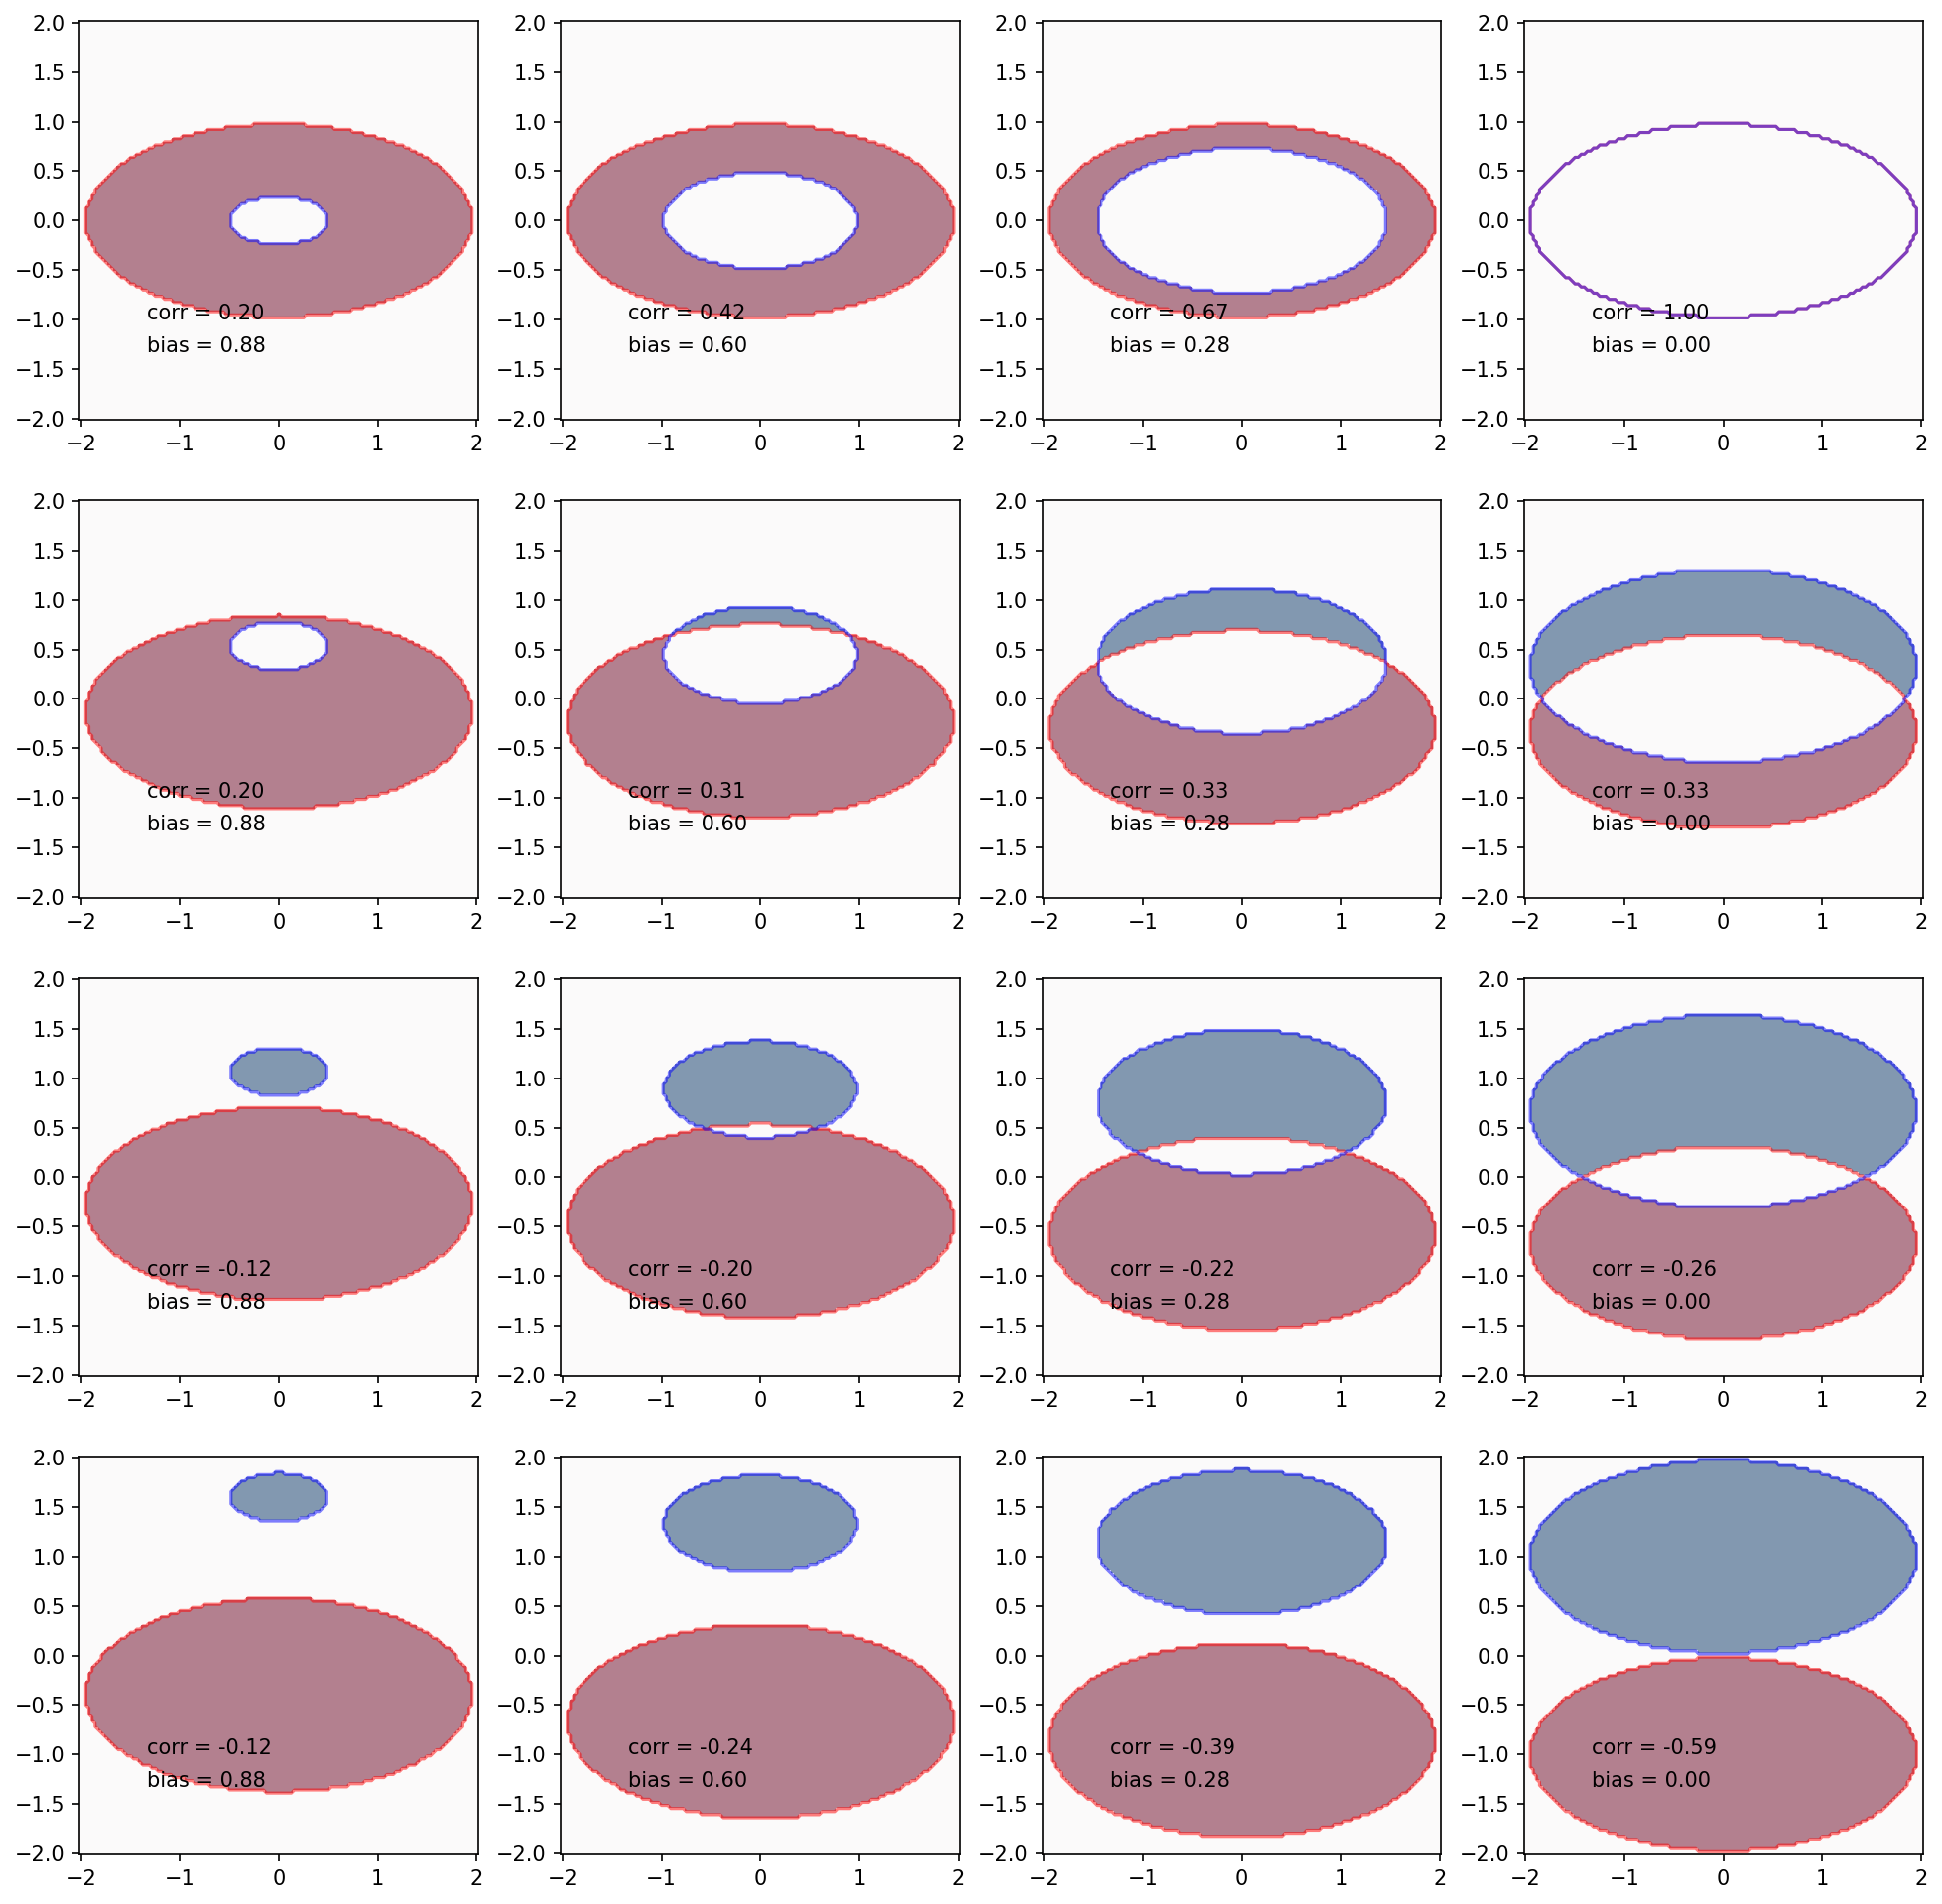

In [127]:
fig,axs = plt.subplots(4,4,figsize=(16,16),dpi=150)

for i,d in enumerate(np.linspace(0,2,4)):
    for j,r in enumerate([0.25,0.5,0.75,1]):
        ON = (ellipse_fn(*get_axes(0.5,6     ))(x,y+r/(1+r)*d) > 0).astype(int)
        OF = (ellipse_fn(*get_axes(0.5,6*r**2))(x,y-1/(1+r)*d) > 0).astype(int)
        axs[i,j].imshow(ON-OF,origin='lower',extent=extent,cmap='RdBu_r',vmin=-1,vmax=1,alpha=0.5)
        axs[i,j].contour(ON,origin='lower',extent=extent,levels=[0.5],colors='r',alpha=0.5)
        axs[i,j].contour(OF,origin='lower',extent=extent,levels=[0.5],colors='b',alpha=0.5)
    
        corr = np.corrcoef(ON.flatten(),OF.flatten())[0,1]
        bias = np.abs((ON.sum() - OF.sum()) / (ON.sum() + OF.sum()))
        
        axs[i,j].text(-L/3,-L/4,'corr = {:.2f}'.format(corr))
        axs[i,j].text(-L/3,-L/3,'bias = {:.2f}'.format(bias))

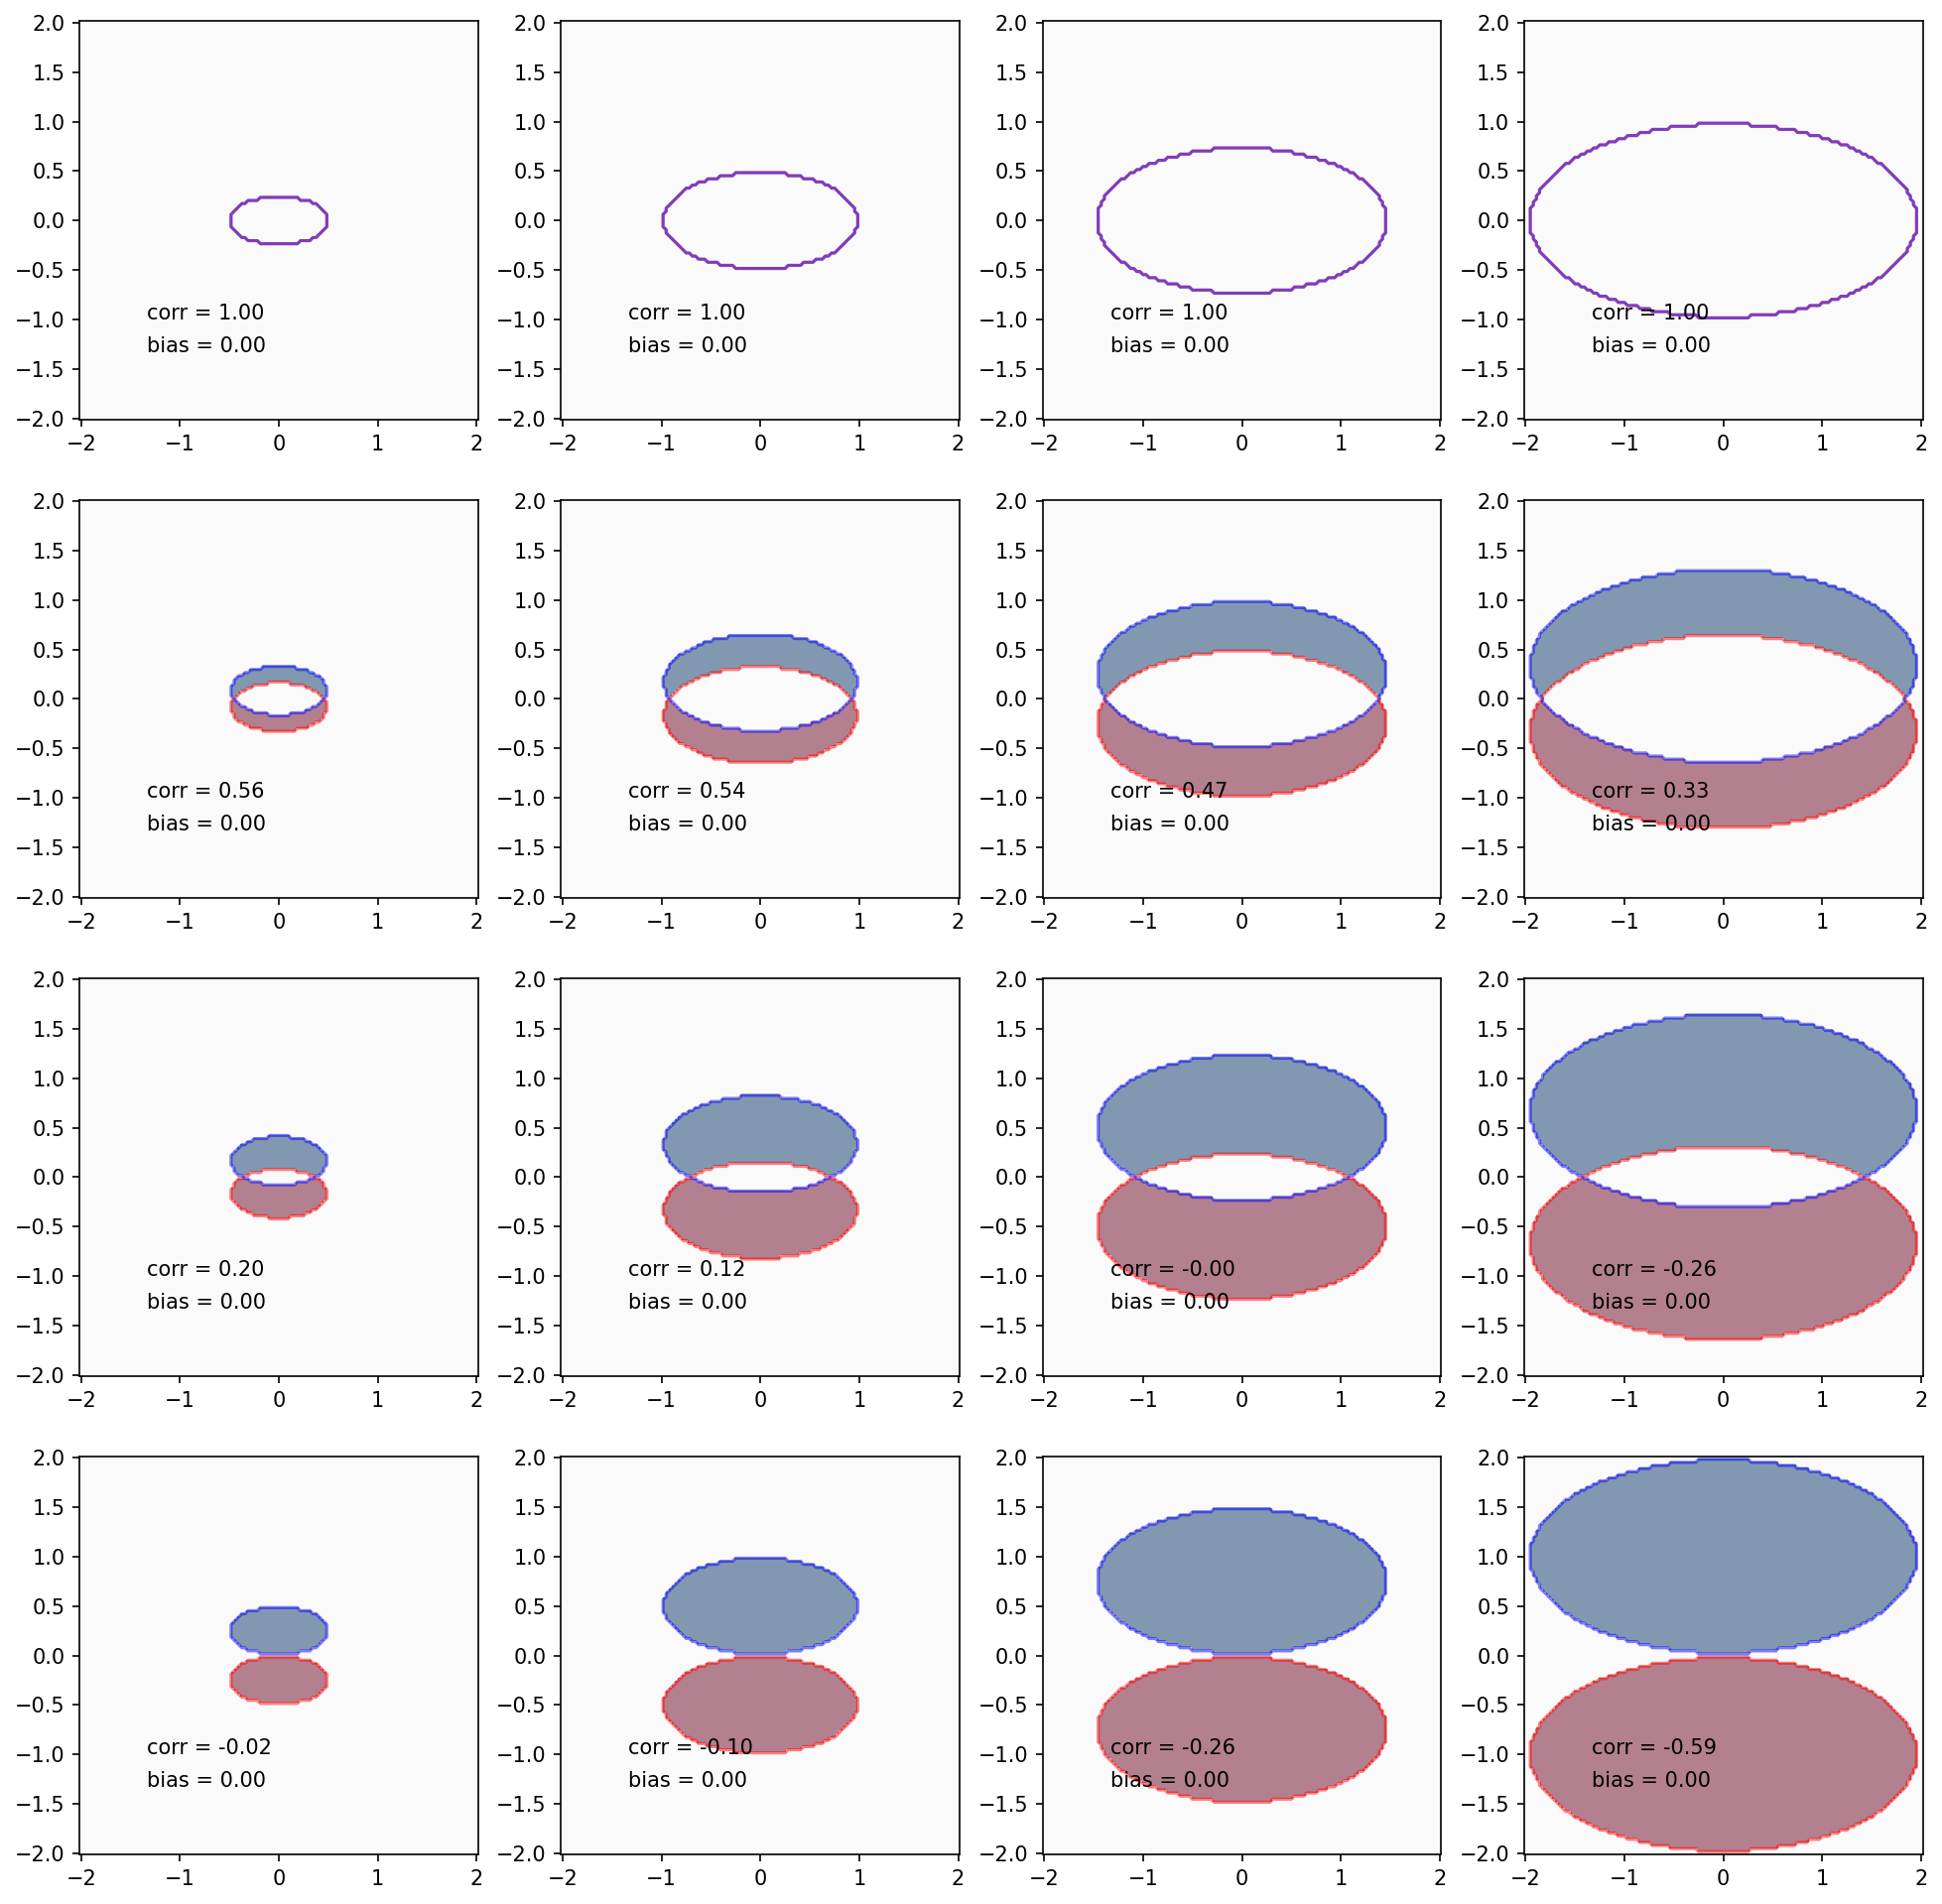

In [121]:
fig,axs = plt.subplots(4,4,figsize=(16,16),dpi=150)

for i,d in enumerate(np.linspace(0,2,4)):
    for j,s in enumerate([0.25,0.5,0.75,1]):
        ON = (ellipse_fn(*get_axes(0.5,6*s**2))(x,y+d*s/2) > 0).astype(int)
        OF = (ellipse_fn(*get_axes(0.5,6*s**2))(x,y-d*s/2) > 0).astype(int)
        axs[i,j].imshow(ON-OF,origin='lower',extent=extent,cmap='RdBu_r',vmin=-1,vmax=1,alpha=0.5)
        axs[i,j].contour(ON,origin='lower',extent=extent,levels=[0.5],colors='r',alpha=0.5)
        axs[i,j].contour(OF,origin='lower',extent=extent,levels=[0.5],colors='b',alpha=0.5)
    
        corr = np.corrcoef(ON.flatten(),OF.flatten())[0,1]
        bias = np.abs((ON.sum() - OF.sum()) / (ON.sum() + OF.sum()))
        
        axs[i,j].text(-L/3,-L/4,'corr = {:.2f}'.format(corr))
        axs[i,j].text(-L/3,-L/3,'bias = {:.2f}'.format(bias))

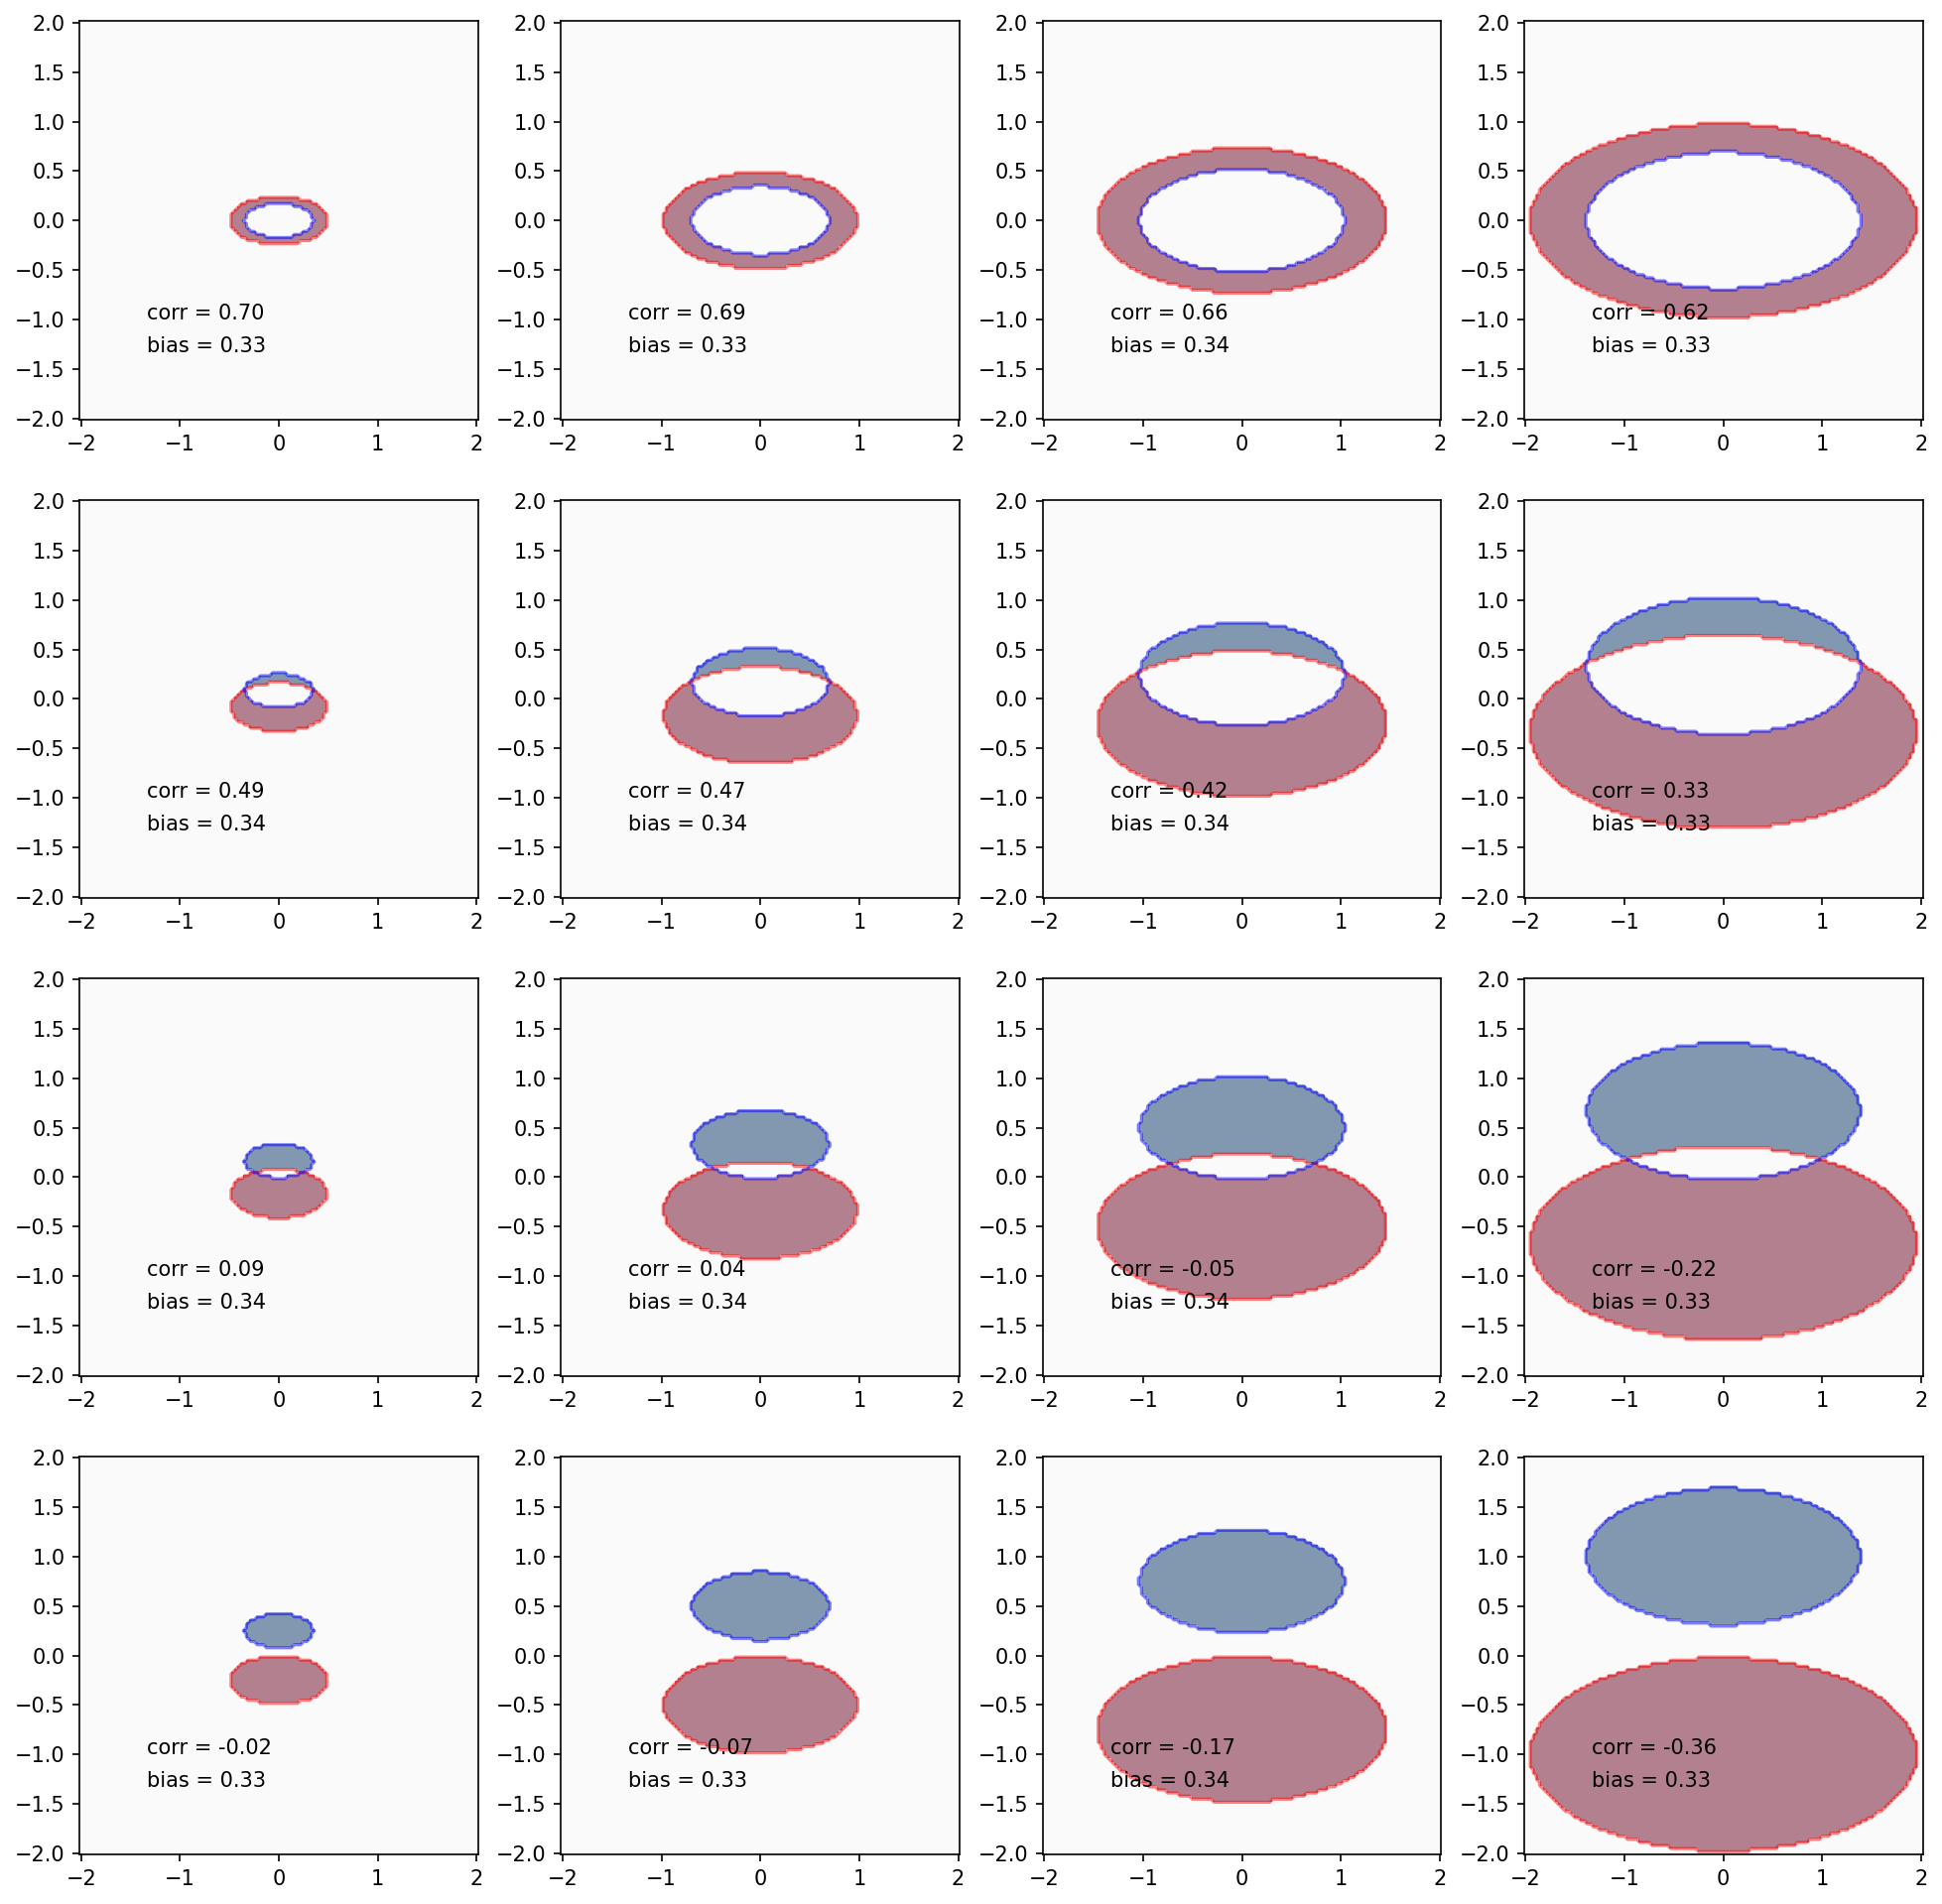

In [122]:
fig,axs = plt.subplots(4,4,figsize=(16,16),dpi=150)

for i,d in enumerate(np.linspace(0,2,4)):
    for j,s in enumerate([0.25,0.5,0.75,1]):
        ON = (ellipse_fn(*get_axes(0.5,6*s**2))(x,y+d*s/2) > 0).astype(int)
        OF = (ellipse_fn(*get_axes(0.5,0.5*6*s**2))(x,y-d*s/2) > 0).astype(int)
        axs[i,j].imshow(ON-OF,origin='lower',extent=extent,cmap='RdBu_r',vmin=-1,vmax=1,alpha=0.5)
        axs[i,j].contour(ON,origin='lower',extent=extent,levels=[0.5],colors='r',alpha=0.5)
        axs[i,j].contour(OF,origin='lower',extent=extent,levels=[0.5],colors='b',alpha=0.5)
    
        corr = np.corrcoef(ON.flatten(),OF.flatten())[0,1]
        bias = np.abs((ON.sum() - OF.sum()) / (ON.sum() + OF.sum()))
        
        axs[i,j].text(-L/3,-L/4,'corr = {:.2f}'.format(corr))
        axs[i,j].text(-L/3,-L/3,'bias = {:.2f}'.format(bias))